In [229]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import TOFPET_cal_lib as TPcal
from scipy import interpolate
import time
import build_data_df_mine as bd
from functools import partial
import multiprocessing as mp
from scipy.stats import skewnorm

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def event_selection(df,column):
    max_pos = df[column].argmax()
    res1 = df.iloc[max_pos]['sensor_id'] in [44,45,54,55]
    
    df_aux = df['sensor_id'].isin([11,12,13,14,15,16,17,18,21,28,31,38,41,48,
                                   51,58,61,68,71,78,81,82,83,84,85,86,87,88])
    if df_aux.any():
        res2 = False
    else:
        res2 = True
        
    return res1  & res2

In [3]:
def event_selection_center(df,column):
    max_pos = df[column].argmax()
    res1 = df.iloc[max_pos]['sensor_id'] in [44,45,54,55]
    return res1

In [4]:
def exp_tot(x,A,B):
    
    return A*np.exp(x*5/B)

In [5]:
def ToT2pe(x,df_ToT2pe):
    return df_ToT2pe.iloc[(np.abs(df_ToT2pe['ToT_ns']-x*5)).argmin()]['pe']
    

In [128]:
run = 11309
#run = 11302
asic = 0
path_data = "/analysis/" + str(run) + "/hdf5/proc/linear_interp/files/"
#path_data = "/home/vherrero/CALIBRATION_FILES/"
path_image_out = "/home/vherrero/RESULTS/images/"

In [7]:
def pre_process(run_number,file_number):
    
    hi_ToT = 500
    lo_ToT = 0
    
    energy1_array = []
    energy2_array = []
    energy3_array = []
        
    file_data = path_data + 'run_' + str(run_number) +\
                    '_'+ str(file_number).zfill(4) + '_trigger1_waveforms.h5'

    with pd.HDFStore(file_data,'r',complib="zlib",complevel=4) as storage:
        keys = storage.keys()
        for j in [keys[i] for i in range(10)]:
            print("File %i | Chunk %s" % (file_number,j))
            data = pd.read_hdf(file_data,j) #,stop=10000)

            # Apply Filtering
            #data_f = data[(data['intg_w']<hi_intg_w)&(data['intg_w']>lo_intg_w) & (data['cluster']!=-1) ]
            data_f = data[(data['cluster']!=-1)] 
            
            # Coincidence Filter
            coincidence   = data_f.groupby(['cluster','evt_number'])['tofpet_id'].nunique()
            data_f_idx    = data_f.set_index(['cluster','evt_number'])
            data_f        = data_f_idx.loc[coincidence[coincidence == 2].index]
            
            # Only TOFPET0
            data_f0 = data_f.loc[(data_f['tofpet_id']==0)]
            
            # ToT computation
            data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
            
            # Get rid of abnormaly long ToT
            data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
            
            # Event selection based on Maximum Charge
            sel = data_f0.groupby(['cluster','evt_number']).apply(event_selection_center,column='intg_w_ToT')
            data_f1 = data_f0[sel]
                                   
            energy1 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
                
            energy1_array.extend(energy1['intg_w_ToT'].to_numpy())           
        
    return energy1_array, data_f1

In [81]:
def process_energy(run_number,table,file_number):
    
    #hi_ToT = 500
    #lo_ToT = 0
    
    lo_ToT = 25#table.iloc[0]['ToT_ns']/5.0
    hi_ToT = table.iloc[-1]['ToT_ns']/5.0
    
    energy1_array = []
    energy2_array = []
    energy3_array = []
    data_df_aux = []
        
    file_data = path_data + 'run_' + str(run_number) +\
                    '_'+ str(file_number).zfill(4) + '_trigger1_waveforms.h5'

    with pd.HDFStore(file_data,'r',complib="zlib",complevel=4) as storage:
        keys = storage.keys()
        for j in [keys[i] for i in range(10)]:
            print("File %i | Chunk %s" % (file_number,j))
            data = pd.read_hdf(file_data,j) #,stop=10000)

            # Apply Filtering
            #data_f = data[(data['intg_w']<hi_intg_w)&(data['intg_w']>lo_intg_w) & (data['cluster']!=-1) ]
            data_f = data[(data['cluster']!=-1)] 
            
            # Coincidence Filter
            coincidence   = data_f.groupby(['cluster','evt_number'])['tofpet_id'].nunique()
            data_f_idx    = data_f.set_index(['cluster','evt_number'])
            data_f        = data_f_idx.loc[coincidence[coincidence == 2].index]
            
            # Only TOFPET0
            data_f0 = data_f.loc[(data_f['tofpet_id']==0)]
            
            # ToT computation
            data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
            
            # Get rid of abnormaly long ToT
            data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
            
            # Event selection based on Maximum Charge
            sel = data_f0.groupby(['cluster','evt_number']).apply(event_selection_center,column='intg_w_ToT')
            data_f1 = data_f0[sel]
            #data_f0['ToT_pe'] = data_f0['intg_w'].apply(exp_tot, A=0.21193678,B=50.07888458)
            data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
                                   
            energy1 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
            energy2 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w'].sum()
            energy3 = data_f1.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
            
            energy1_array.extend(energy1['intg_w_ToT'].to_numpy())           
            energy2_array.extend(energy2['intg_w'].to_numpy())
            energy3_array.extend(energy3['ToT_pe'].to_numpy())
            data_df_aux.append(data_f1)
            data_df_T = pd.concat(data_df_aux)
        
    return energy1_array, energy2_array, energy3_array, data_df_T

In [82]:
def process_best_res(run_number,table,df):
    
    #hi_ToT = 500
    #lo_ToT = 0
    
    lo_ToT = table.iloc[0]['ToT_ns']/5.0
    hi_ToT = table.iloc[-1]['ToT_ns']/5.0
            
    energy_ToT_pe = df.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
    
    
        
    return energy1_array, energy2_array, energy3_array, data_df_T

energy_ToT_pe = df_out.groupby(['cluster','evt_number'])['ToT_pe'].sum()

plt.figure()
energy_ToT_pe.hist(bins=200,range=[150,2500])

energy_sel_index = (energy_ToT_pe>1300) & (energy_ToT_pe<1750)
energy_sel = energy_ToT_pe[energy_sel_index]

df_out_sel = df_out.loc[energy_sel.index]

df_small = df_out_sel[df_out_sel.groupby(['cluster','evt_number']).apply(event_selection,column='ToT_pe')]

df_small_energy = df_small.groupby(['cluster','evt_number'])['ToT_pe'].sum()
df_out_sel_energy = df_out_sel.groupby(['cluster','evt_number'])['ToT_pe'].sum()

len(df_small_energy)

plt.figure()
df_small_energy.hist(bins=50)

def post_process(filename,table_name):
    
    #path_out             = "/home/vherrero/RESULTS/"
    #filename_processed   = "run_"+str(run)+"_results_d.h5"
    
    table = pd.read_hdf("/home/vherrero/CALIBRATION_FILES/" + table_name,'/ToT_T2')
    data_f0 = pd.read_hdf(filename,'df_out')
    
    lo_ToT = table.iloc[0]['ToT_ns']/5.0
    hi_ToT = table.iloc[-1]['ToT_ns']/5.0
    
    print(lo_ToT,hi_ToT)
    
    energy1_array = []
    energy3_array = []
       
    # ToT filtering (based on table data)
    #data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
    #print("ToT filtering applied")
    
    print("New ToT_pe table")
    data_f0['ToT_pe'] = data_f0['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
    
    print("Computing Energy")
    energy1 = data_f0.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
    energy3 = data_f0.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
    
    
    energy1_array = energy1['intg_w_ToT'].to_numpy()
    energy3_array = energy3['ToT_pe'].to_numpy()
        
    return energy1_array, energy3_array, data_f0

# Preprocessing to find mean ToT for Max SiPM (50pe according MC) 

In [124]:
n_files = 20

out1 = []
df_array = []

process_energy_mp = partial(pre_process,run) 

pool = mp.Pool(processes = n_files)

pool_output = pool.map(process_energy_mp, range(n_files))

pool.close()
pool.join()

sizes = np.shape(pool_output)

for x in range(sizes[0]):
    out1.extend(pool_output[x][0])
    df_array.append(pool_output[x][1])
        
out1   = np.array(out1)
df_out = pd.concat(df_array)

File 11 | Chunk /data_0File 6 | Chunk /data_0

File 12 | Chunk /data_0
File 3 | Chunk /data_0
File 0 | Chunk /data_0
File 14 | Chunk /data_0
File 5 | Chunk /data_0
File 2 | Chunk /data_0
File 7 | Chunk /data_0
File 4 | Chunk /data_0
File 8 | Chunk /data_0
File 17 | Chunk /data_0
File 10 | Chunk /data_0
File 9 | Chunk /data_0
File 19 | Chunk /data_0
File 15 | Chunk /data_0


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 1 | Chunk /data_0
File 16 | Chunk /data_0
File 18 | Chunk /data_0
File 13 | Chunk /data_0


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 3 | Chunk /data_1
File 12 | Chunk /data_1
File 11 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 0 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 5 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 14 | Chunk /data_1
File 17 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 7 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 4 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 10 | Chunk /data_1
File 19 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 8 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 15 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 3 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 12 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 11 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 16 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_1
File 13 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 17 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 2 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_10File 7 | Chunk /data_10

File 4 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_10
File 10 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 8 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 6 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 3 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_10
File 12 | Chunk /data_100
File 11 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 16 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 18 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 7 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 4 | Chunk /data_100
File 2 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_100
File 5 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_100
File 10 | Chunk /data_100
File 14 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 8 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 19 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 6 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 12 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 11 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 15 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_101
File 0 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 16 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 7 | Chunk /data_101
File 18 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_100
File 4 | Chunk /data_101
File 2 | Chunk /data_101
File 1 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 10 | Chunk /data_101
File 19 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 8 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 5 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 9 | Chunk /data_101
File 6 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 11 | Chunk /data_102
File 12 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 15 | Chunk /data_101
File 3 | Chunk /data_102
File 0 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 7 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_101
File 4 | Chunk /data_102
File 16 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 1 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 10 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 18 | Chunk /data_101
File 8 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_103
File 5 | Chunk /data_102
File 17 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 14 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 11 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 15 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 3 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 4 | Chunk /data_103
File 16 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 1 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 7 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_102
File 8 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_103
File 5 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 10 | Chunk /data_103
File 2 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 11 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 14 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 17 | Chunk /data_103
File 15 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_104
File 12 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 0 | Chunk /data_104
File 3 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 4 | Chunk /data_104
File 16 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 7 | Chunk /data_104
File 1 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 8 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 5 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 11 | Chunk /data_105
File 10 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 15 | Chunk /data_104
File 2 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 14 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_104
File 12 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 0 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 16 | Chunk /data_104
File 4 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 18 | Chunk /data_104
File 8 | Chunk /data_105
File 1 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 7 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 13 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 11 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 10 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 14 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_105
File 16 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 12 | Chunk /data_106
File 4 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 8 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 7 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_106
File 18 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 5 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 15 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 10 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 14 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 2 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 18 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 16 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

<IPython.core.display.Javascript object>


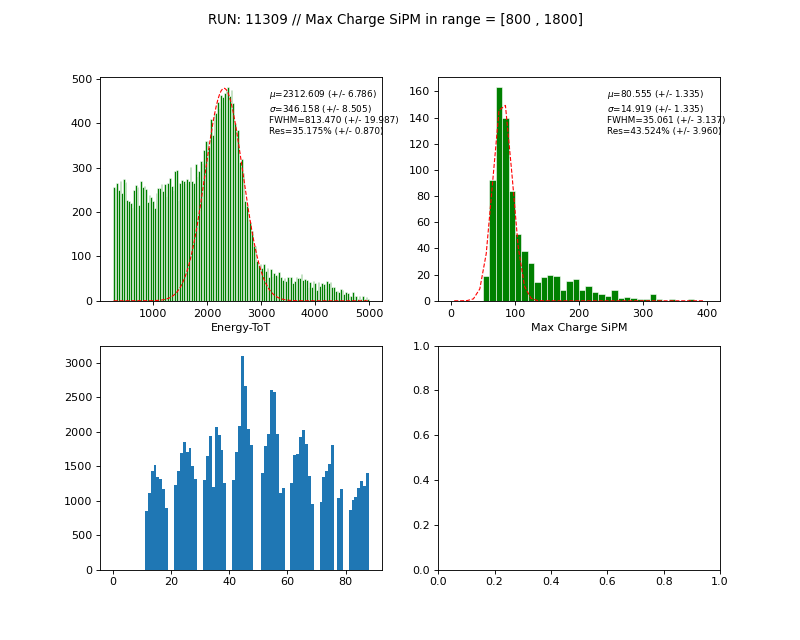

(array([ 479.36418036, 2312.60929484,  346.15764889]), array([5.86714754, 6.78561227, 8.50524526]), 1.0635435911743427)
(array([156.07010434,  80.55459623,  14.91947627]), array([12.09299981,  1.33486491,  1.33486524]), 656216757422.1332)


In [137]:
low  = 800
high = 1800

energy_w   = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()

df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
max_charge  = df_filtered.groupby(['cluster','evt_number'])['intg_w_ToT'].max()
#ch_filtered = df_filtered.loc[df_filtered['sensor_id']==sipm]

fig, axis = plt.subplots(2,2,figsize=(10,8))
fig.suptitle(("RUN: %i" % run) + (" // Max Charge SiPM in range = [%i , %i]  " % (low,high)) )

coeff=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2000,2900],[125,2900,300])

coeff2=TPcal.gauss_fit2(max_charge,40,True,axis[0,1],"Max Charge SiPM","","",[0.6,0.95,"left"],
                 [0,400],[0,200],[17,100,10])

axis[1,0].hist(df_out['sensor_id'],bins=88,range=[0,88])

fig.savefig(path_image_out+"preprocess.png")
#plt.tight_layout()
print(coeff)
print(coeff2)

# SLOW PROCESSING

In [138]:
n_files = 80

path_out             = "/home/vherrero/CALIBRATION_FILES/"
filename_ToT_table   = "ToT_PE_conversion12d_high.h5"
table = pd.read_hdf(path_out + filename_ToT_table,'/ToT_T2')

out1 = []
out2 = []
out3 = []
df_array = []
#process_typical_charge_mp = partial(process_typical_charge,run) 
process_energy_mp = partial(process_energy,run,table) 
#process_max_charge_mp = partial(process_max_charge,run) 

pool = mp.Pool(processes = n_files)

#pool_output = pool.map(process_typical_charge_mp, range(n_files))
pool_output = pool.map(process_energy_mp, range(n_files))
#pool_output = pool.map(process_max_charge_mp, range(n_files))

pool.close()
pool.join()

sizes = np.shape(pool_output)

for x in range(sizes[0]):
    out1.extend(pool_output[x][0])
    out2.extend(pool_output[x][1])
    out3.extend(pool_output[x][2])
    df_array.append(pool_output[x][3])
        
out1   = np.array(out1)
out2   = np.array(out2)
out3   = np.array(out3)
df_out = pd.concat(df_array)


File 46 | Chunk /data_0File 22 | Chunk /data_0File 49 | Chunk /data_0File 27 | Chunk /data_0File 30 | Chunk /data_0File 6 | Chunk /data_0File 28 | Chunk /data_0File 43 | Chunk /data_0File 48 | Chunk /data_0File 26 | Chunk /data_0File 15 | Chunk /data_0File 10 | Chunk /data_0File 7 | Chunk /data_0File 44 | Chunk /data_0File 17 | Chunk /data_0File 37 | Chunk /data_0File 47 | Chunk /data_0File 38 | Chunk /data_0File 23 | Chunk /data_0File 33 | Chunk /data_0File 5 | Chunk /data_0File 21 | Chunk /data_0File 11 | Chunk /data_0File 24 | Chunk /data_0File 9 | Chunk /data_0File 40 | Chunk /data_0File 8 | Chunk /data_0File 14 | Chunk /data_0File 20 | Chunk /data_0File 39 | Chunk /data_0File 4 | Chunk /data_0File 0 | Chunk /data_0File 34 | Chunk /data_0File 32 | Chunk /data_0File 31 | Chunk /data_0File 29 | Chunk /data_0File 3 | Chunk /data_0File 35 | Chunk /data_0File 2 | Chunk /data_0File 19 | Chunk /data_0File 25 | Chunk /data_0File 45 | Chunk /data_0File 41 | Chunk /data_0File 12 | Chunk /dat

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 50 | Chunk /data_0


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 52 | Chunk /data_0


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 61 | Chunk /data_0
File 53 | Chunk /data_0
File 54 | Chunk /data_0File 76 | Chunk /data_0


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 62 | Chunk /data_0
File 67 | Chunk /data_0File 57 | Chunk /data_0

File 77 | Chunk /data_0
File 51 | Chunk /data_0
File 70 | Chunk /data_0


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 79 | Chunk /data_0


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 73 | Chunk /data_0
File 65 | Chunk /data_0
File 60 | Chunk /data_0
File 55 | Chunk /data_0
File 64 | Chunk /data_0
File 63 | Chunk /data_0
File 74 | Chunk /data_0File 69 | Chunk /data_0

File 66 | Chunk /data_0
File 71 | Chunk /data_0File 72 | Chunk /data_0



<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 33 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 12 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 11 | Chunk /data_1
File 36 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 21 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_1
File 31 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 44 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 1 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 26 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 46 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 35 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 49 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 42 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 48 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 30 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 24 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 20 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 40 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 47 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_1
File 45 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 41 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 43 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 2 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 38 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_1

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 17 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 44 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 25 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 46 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 12 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 35 | Chunk /data_10
File 21 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 49 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

File 31 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 33 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 11 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 26 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Ser

File 1 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 42 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 

File 62 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 53 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 7 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 50 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 78 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_10
File 30 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 76 | Chunk /data_1
File 54 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 71 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 58 | Chunk /data_1
File 10 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 69 | Chunk /data_1
File 74 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 75 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 59 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 51 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 24 | Chunk /data_10
File 34 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 60 | Chunk /data_1
File 3 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_10
File 55 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 44 | Chunk /data_100

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 41 | Chunk /data_10
File 63 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 64 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 37 | Chunk /data_10
File 43 | Chunk /data_10
File 61 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 77 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 48 | Chunk /data_10
File 73 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 66 | Chunk /data_1

<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_100File 0 | Chunk /data_10

File 67 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 45 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 20 | Chunk /data_10File 68 | Chunk /data_1



<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 52 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 56 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 57 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 65 | Chunk /data_1File 46 | Chunk /data_100

File 72 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 79 | Chunk /data_1


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 47 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 29 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 2 | Chunk /data_10
File 40 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 19 | Chunk /data_10
File 35 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 70 | Chunk /data_1
File 27 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 49 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 17 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 42 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 12 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 26 | Chunk /data_100

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 11 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 22 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 6 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 33 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 1 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 

File 7 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 53 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 36 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 

File 32 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 13 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 5 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 16 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 76 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 

File 10 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A va

File 9 | Chunk /data_100
File 78 | Chunk /data_10
File 30 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 62 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 41 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 48 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 19 | Chunk /data_100
File 24 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 40 | Chunk /data_100
File 21 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 34 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 46 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 44 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 35 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 3 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 39 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 58 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 29 | Chunk /data_100
File 0 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 54 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 59 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 50 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 43 | Chunk /data_100
File 75 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 71 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 49 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A va

File 4 | Chunk /data_100
File 28 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 42 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 64 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 47 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 20 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_101
File 26 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 25 | Chunk /data_101
File 63 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 2 | Chunk /data_100

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 45 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 74 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 69 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 27 | Chunk /data_100
File 68 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 60 | Chunk /data_10
File 51 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 12 | Chunk /data_101
File 14 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 73 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 17 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 66 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 55 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 76 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 79 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 65 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 61 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 52 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 32 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 67 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 57 | Chunk /data_10
File 7 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 77 | Chunk /data_10
File 56 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 1 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 16 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 53 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 72 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 15 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 36 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 70 | Chunk /data_10


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 10 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 30 | Chunk /data_101
File 23 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 58 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 62 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 19 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Ser

File 78 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 46 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 41 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 21 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 40 | Chunk /data_101
File 6 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 24 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 48 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 47 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 44 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 49 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 35 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 54 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 71 | Chunk /data_100
File 39 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 26 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 75 | Chunk /data_100
File 4 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 43 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 29 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 59 | Chunk /data_100
File 22 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 69 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 55 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 50 | Chunk /data_100File 25 | Chunk /data_102



<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 14 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 64 | Chunk /data_100
File 28 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 45 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 3 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 7 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 51 | Chunk /data_100
File 60 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 52 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 66 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 31 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 73 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 68 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 74 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 53 | Chunk /data_101File 12 | Chunk /data_102



<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 1 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 63 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 13 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_102

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 33 | Chunk /data_102
File 20 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 77 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 42 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 76 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 17 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 70 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 57 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 65 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 79 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 11 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 67 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 62 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 56 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 61 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 58 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 

File 30 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 36 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 78 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 16 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 72 | Chunk /data_100


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 23 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 21 | Chunk /data_103
File 5 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_102

<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 40 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 38 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 46 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 48 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 41 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 55 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 71 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 47 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 75 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 25 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 52 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 44 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 35 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A va

File 1 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 26 | Chunk /data_103
File 59 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 29 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series k

File 50 | Chunk /data_101
File 13 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 33 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 54 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 43 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 64 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 3 | Chunk /data_102
File 37 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 51 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 45 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 79 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 74 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 69 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 31 | Chunk /data_103
File 73 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 28 | Chunk /data_102
File 0 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 49 | Chunk /data_103
File 14 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 20 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 68 | Chunk /data_101
File 60 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 61 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 66 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 34 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 76 | Chunk /data_102
File 8 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 32 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

File 56 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 53 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 42 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 77 | Chunk /data_101
File 62 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A va

File 63 | Chunk /data_101
File 57 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 55 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 65 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 67 | Chunk /data_101
File 11 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 21 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 23 | Chunk /data_103
File 12 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 70 | Chunk /data_101


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 

File 15 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 24 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 40 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 58 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 18 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 30 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 4 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 72 | Chunk /data_101
File 19 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 48 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 7 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 78 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 50 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 46 | Chunk /data_104
File 75 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 51 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 71 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 10 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 47 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

File 38 | Chunk /data_103
File 52 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 26 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 41 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 64 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_104File 8 | Chunk /data_104



<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 35 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 74 | Chunk /data_102

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 44 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 0 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 73 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 60 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 69 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 54 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 59 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 66 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 43 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 68 | Chunk /data_102
File 45 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 79 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 20 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 49 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 62 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 42 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 31 | Chunk /data_104
File 27 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 57 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 55 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 28 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 76 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 32 | Chunk /data_104
File 2 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 70 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 11 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 63 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 56 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 65 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 16 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 61 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 53 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 21 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 67 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 77 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 48 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 46 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 51 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 58 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 78 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

File 5 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 40 | Chunk /data_104
File 4 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 50 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 12 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 52 | Chunk /data_103
File 18 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A va

File 19 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 75 | Chunk /data_103File 13 | Chunk /data_105



<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

File 7 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 41 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 30 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 72 | Chunk /data_102


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 35 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 71 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 39 | Chunk /data_104
File 6 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 64 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 73 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 47 | Chunk /data_104File 8 | Chunk /data_105



<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 44 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 33 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 54 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_104
File 43 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 9 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 42 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_104
File 63 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 26 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 29 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 69 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 68 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_105
File 45 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 60 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 59 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 66 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 74 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 79 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 24 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 51 | Chunk /data_104

<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 22 | Chunk /data_105

<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 49 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 62 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be rei

File 27 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 56 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 28 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 57 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 20 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 55 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 11 | Chunk /data_105
File 14 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying 

File 67 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 70 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will

File 53 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_106


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 2 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 76 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 48 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 21 | Chunk /data_106


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 78 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 52 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying 

File 23 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 30 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is 

File 75 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 16 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 58 | Chunk /data_104


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 61 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is 

File 40 | Chunk /data_105
File 65 | Chunk /data_103


<ipython-input-81-c2f465e7b951>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-81-c2f465e7b951>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 18 | Chunk /data_106
File 5 | Chunk /data_105


<ipython-input-81-c2f465e7b951>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 46 | Chunk /data_106

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<IPython.core.display.Javascript object>


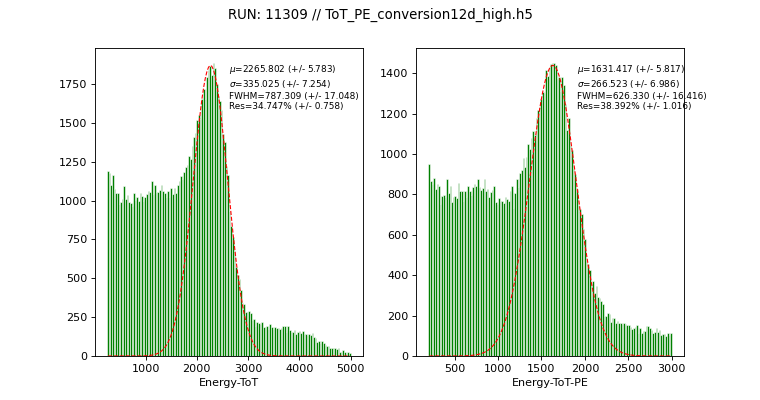

In [152]:
fig, axis = plt.subplots(1,2,figsize=(9.5,5))

#axis[0].hist(energy_window_array1,bins=50,range=[80,4000],log=False)
#axis[1].hist(energy_efine_array1,bins=50,range=[25,800],log=False)
#axis[0].set_title("Integ. Window Coincidence")
#axis[1].set_title("Efine Corrected Coincidence")

fig.suptitle("RUN: %i // %s" % (run,filename_ToT_table))

axis[0].set_title("T2-T1")
coeff1=TPcal.gauss_fit2(out1,150,True,axis[0],"Energy-ToT","","",[0.5,0.95,"left"]
                 ,[250,5000],[2000,2800],[125,2000,300])


coeff3=TPcal.gauss_fit2(out3,150,True,axis[1],"Energy-ToT-PE","","",[0.6,0.95,"left"]
                 ,[200,3000],[1500,2000],[125,1500,10])




# Peak Scanner

low  = 2300
high = 3300
energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
energy3 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
energy4 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()



fig, axis = plt.subplots(3,2,figsize=(9,9))
fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] " % (low,high)) )
axis[0,0].hist(df_filtered['ToT_pe'],bins=400,range=[0,200],alpha=0.8)
axis[0,0].set_title("ToT_pe")
axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,3000],alpha=0.8)
axis[0,1].set_title("Energy (using ToT_pe)")
axis[1,0].hist(df_filtered['intg_w_ToT'],bins=1600,range=[0,150],alpha=0.8)
axis[1,0].hist(df_filtered['intg_w'],bins=1600,range=[0,75],alpha=0.8)
axis[1,0].set_title("ToT")
axis[1,1].set_title("Energy (using intg_w_ToT)")
axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
axis[2,0].set_title("Channels")
axis[2,0].hist(df_filtered['sensor_id'],bins=64,range=[0,64],alpha=0.8)

<IPython.core.display.Javascript object>


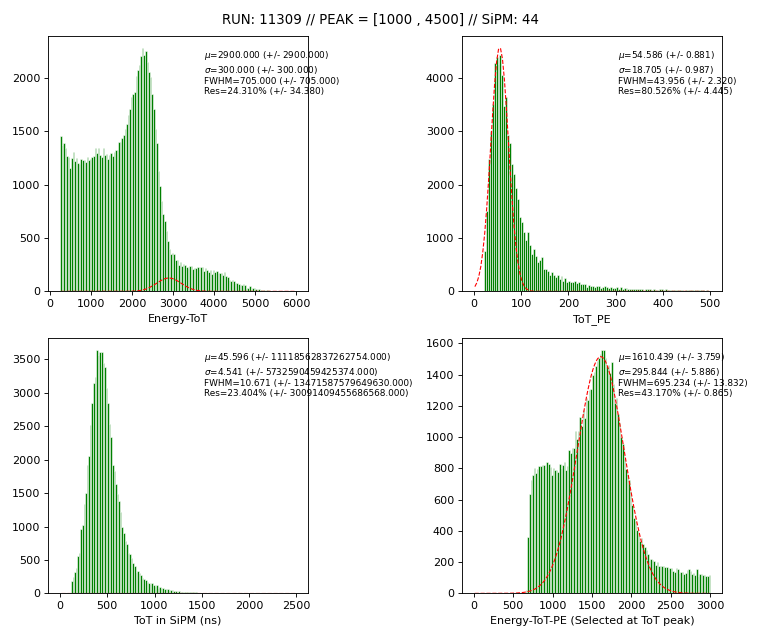

Fitting Problems


/volumedisk0/home/vherrero/PETALO_analysis/TOFPET_cal_lib.py:284: RuntimeWarning: divide by zero encountered in true_divide
  self.chisq = np.sum((((self.hist_f-self.hist_fit_f)**2)/self.hist_fit_f))


In [140]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))
low  = 1000
high = 4500
sipm = 44

energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
ch_filtered = df_filtered.loc[df_filtered['sensor_id']==sipm]

energy3 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()


fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (low,high,sipm)) )


coeff1=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,6000],[2500,3500],[125,2900,300])


coeff2=TPcal.gauss_fit2(ch_filtered['ToT_pe'],120,True,axis[0,1],"ToT_PE","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])


coeff3=TPcal.gauss_fit2(ch_filtered['intg_w_ToT']*5,150,True,axis[1,0],"ToT in SiPM (ns)","","",[0.6,0.95,"left"]
                 ,[0,2500],[10,500],[125,50,20])

coeff4=TPcal.gauss_fit2(energy3,150,True,axis[1,1],"Energy-ToT-PE (Selected at ToT peak)","","",[0.6,0.95,"left"]
                 ,[0,3000],[1300,2000],[125,1700,20])


#axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,2000],alpha=0.8)
#axis[0,1].set_title("Energy (using ToT_pe)")
#axis[1,0].hist(ch_filtered['intg_w_ToT'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].hist(ch_filtered['intg_w'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].set_title("ToT")
#axis[1,1].set_title("Energy (using intg_w_ToT)")
#axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
plt.tight_layout()

<IPython.core.display.Javascript object>


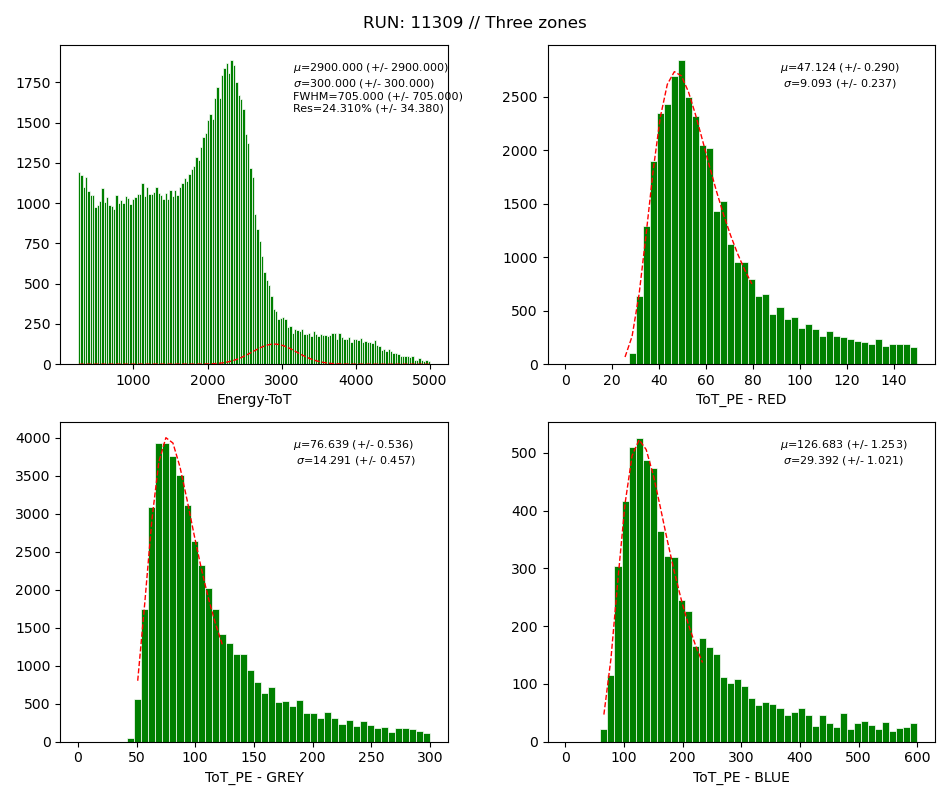

Fitting Problems
(array([6.34521321e+04, 1.26682683e+02, 2.93923962e+01]), array([1.72115172e+03, 1.25275748e+00, 1.02123983e+00]), 3.8338955445952987)


In [258]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))

low1  = 300
high1 = 1700
low2  = 1700
high2 = 3000
low3  = 3000
high3 = 4250

sipm = 44

energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()


df_filtered1 = df_out.loc[(energy_w>low1) & (energy_w<high1)]
max_charge1  = df_filtered1.groupby(['cluster','evt_number'])['ToT_pe'].max()
df_filtered2 = df_out.loc[(energy_w>low2) & (energy_w<high2)]
max_charge2  = df_filtered2.groupby(['cluster','evt_number'])['ToT_pe'].max()
df_filtered3 = df_out.loc[(energy_w>low3) & (energy_w<high3)]
max_charge3  = df_filtered3.groupby(['cluster','evt_number'])['ToT_pe'].max()

#ch_filtered1 = df_filtered1.loc[df_filtered1['sensor_id']==sipm]
#ch_filtered2 = df_filtered2.loc[df_filtered2['sensor_id']==sipm]
#ch_filtered3 = df_filtered3.loc[df_filtered3['sensor_id']==sipm]



fig.suptitle(("RUN: %i" % run) + " // Three zones" )


coeff1=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])


coeff2=TPcal.semigauss_fit2(max_charge1,50,True,axis[0,1],"ToT_PE - RED","","",[0.6,0.95,"left"]
                 ,[0,150],[25,80],[1,50,40])
coeff3=TPcal.semigauss_fit2(max_charge2,50,True,axis[1,0],"ToT_PE - GREY","","",[0.6,0.95,"left"]
                 ,[0,300],[47,125],[1,70,70])
coeff4=TPcal.semigauss_fit2(max_charge3,50,True,axis[1,1],"ToT_PE - BLUE","","",[0.6,0.95,"left"]
                 ,[0,600],[60,240],[1,134,200])

print(coeff4)
plt.tight_layout()

path_out             = "/home/vherrero/RESULTS/"
filename_processed   = "run_"+str(run)+"_results_e.h5"
with pd.HDFStore(path_out + filename_processed,'w',complib="zlib",complevel=4) as storage:
    df_out1 = pd.DataFrame(out1)
    df_out2 = pd.DataFrame(out2)
    df_out3 = pd.DataFrame(out3)
    storage.put('df_out',df_out,index=False,format='table',data_columns=True)
    storage.put('out1',df_out1)
    storage.put('out2',df_out2)
    storage.put('out3',df_out3)


In [41]:
energy1p,energy3p,df_outp = post_process("/home/vherrero/RESULTS/run_11301_results_e.h5","ToT_PE_conversion10b.h5")

6.2 209.8
New ToT_pe table


KeyboardInterrupt: 

In [ ]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))
lowp  = 2500
highp = 3300
sipmp = 44

energy_wp = df_outp.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filteredp = df_outp.loc[(energy_wp>low) & (energy_wp<high)]
ch_filteredp = df_filteredp.loc[df_filteredp['sensor_id']==sipmp]


fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (lowp,highp,sipmp)) )


coeff1=TPcal.gauss_fit2(energy1p,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])


coeff2=TPcal.gauss_fit2(ch_filteredp['ToT_pe'],150,True,axis[0,1],"ToT_PE","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])


coeff3=TPcal.gauss_fit2(ch_filteredp['intg_w_ToT'],150,True,axis[1,0],"ToT in SiPM","","",[0.6,0.95,"left"]
                 ,[0,500],[10,500],[125,50,20])

coeff4=TPcal.gauss_fit2(energy3p,150,True,axis[1,1],"Energy-ToT-PE","","",[0.6,0.95,"left"]
                 ,[250,3000],[1200,1860],[125,1500,300])

#axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,2000],alpha=0.8)
#axis[0,1].set_title("Energy (using ToT_pe)")
#axis[1,0].hist(ch_filtered['intg_w_ToT'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].hist(ch_filtered['intg_w'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].set_title("ToT")
#axis[1,1].set_title("Energy (using intg_w_ToT)")
#axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
plt.tight_layout()

<IPython.core.display.Javascript object>


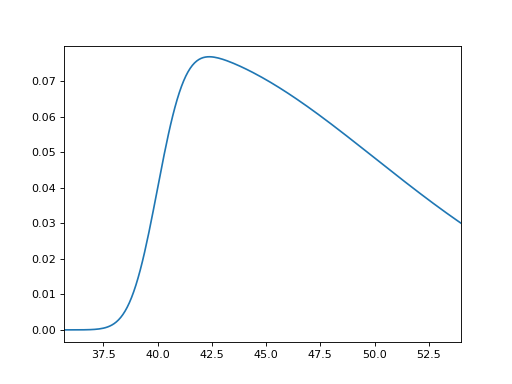

In [252]:
plt.figure()
X = np.arange(-10,100,0.1)
plt.plot(X, skewnorm.pdf(X,10,loc=40,scale=10))



# Events Plot

evt = hama_array[16]
evt2 = fbk_array[16]

fig, axis = plt.subplots(1,2,figsize=(10,4))

image=np.zeros((8,8))
for i in range(len(evt)):
    sipm = evt.iloc[i]['sensor_id']
    y = int(sipm // 10)-1
    x = int(sipm % 10)-1
    image[x,y] = evt.iloc[i]['intg_w']
axis[0].imshow(image)

image=np.zeros((8,8))
for i in range(len(evt2)):
    sipm = evt2.iloc[i]['sensor_id']
    y = int((sipm-100) // 10)-1
    x = int((sipm-100) % 10)-1
    image[x,y] = evt2.iloc[i]['intg_w']
axis[1].imshow(image)